<a href="https://colab.research.google.com/github/Anjalichimnani/EVA4/blob/master/Assignment_11/EVA_S11_CIFAR10_LR_OCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
#https://modelzoo.co/model/data-augmentation-and-sampling-for-pytorch

!google-drive-ocamlfuse -cc

/bin/bash: google-drive-ocamlfuse: command not found


In [0]:
!pip install pytorch-gradcam
!pip install albumentations
!pip install torch-lr-finder -v --global-option="amp"

In [0]:
# Mouting Drive location where all the modularized code is present
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Mapping the Drive location so that the files are loaded
import sys
sys.path.append('/content/drive/My Drive/EVA4/Assignment_11/files/')
from imports.imports_eva import *

from models.CustomNet import CustomNet

from dataloaders import train_test_def as ttd
from dataloaders import albumentation_transform as albumentation_transform

from optimizer.torch_lr_finder.lr_finder import LRFinder

from supplements.Supplements import Supplements

In [0]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

batch_size = 512
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

momentum_min = 0.80
momentum_max = 0.95

In [0]:
trainloader, testloader = albumentation_transform.train_test_loaders(batch_size) 

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Images count 50000
Test Images count 10000


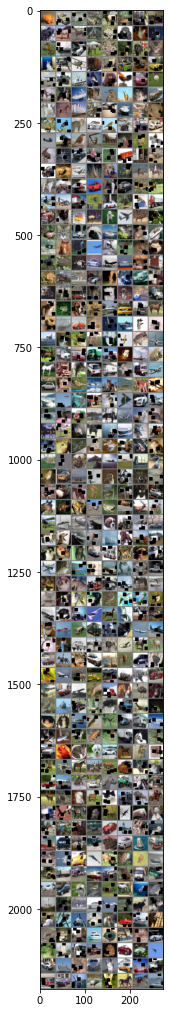

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(28,18))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
# Check the Model Summary - Parameters used and memory consumed. 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         ResBlock-14          [-1,

100%|██████████| 100/100 [03:40<00:00,  2.20s/it]

Learning rate search finished. See the graph with {finder_name}.plot()


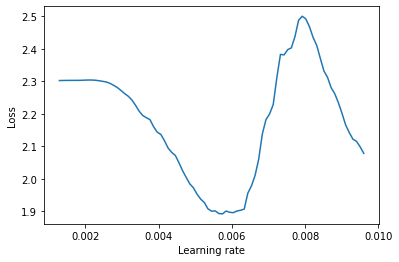

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, start_lr = 0.0001, end_lr=0.01, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)

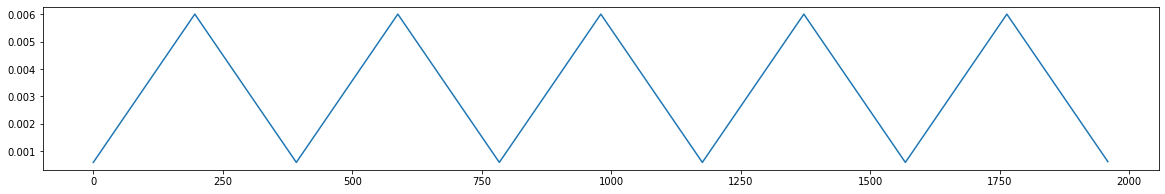

In [0]:
train_set_size = len(trainloader.dataset)
factor_step_iteration = 2
number_of_cycles = 20
lr_max = 0.006
lr_min = lr_max * 0.1

Supplements.show_training_schedule(lr_min, lr_max, train_set_size, batch_size, factor_step_iteration, number_of_cycles)

In [13]:
EPOCHS = 24
epochs_max = 5
lr = lr_min
momentum = momentum_max
model = CustomNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr_max, 
                                          total_steps=EPOCHS, pct_start=(epochs_max/EPOCHS), 
                                          cycle_momentum=True, base_momentum=momentum_min, max_momentum=momentum_max, last_epoch=-1)

for epoch in range(EPOCHS):
    
    
    print("EPOCH:", epoch+1)
    a,b = ttd.train(model, device, trainloader, optimizer, epoch)
    train_losses.extend(a)
    train_accuracy.extend(b)
    c,d = ttd.test(model, device, testloader)
    test_losses.extend(c)
    test_accuracy.extend(d)
    scheduler.step()

    
    print('')

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 4495/10000 (44.95%)


EPOCH: 2


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 5845/10000 (58.45%)


EPOCH: 3


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6623/10000 (66.23%)


EPOCH: 4


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6451/10000 (64.51%)


EPOCH: 5


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6842/10000 (68.42%)


EPOCH: 6


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7394/10000 (73.94%)


EPOCH: 7


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7525/10000 (75.25%)


EPOCH: 8


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7712/10000 (77.12%)


EPOCH: 9


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7928/10000 (79.28%)


EPOCH: 10


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8005/10000 (80.05%)


EPOCH: 11


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7786/10000 (77.86%)


EPOCH: 12


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7969/10000 (79.69%)


EPOCH: 13


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7961/10000 (79.61%)


EPOCH: 14


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8102/10000 (81.02%)


EPOCH: 15


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8132/10000 (81.32%)


EPOCH: 16


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8084/10000 (80.84%)


EPOCH: 17


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8160/10000 (81.60%)


EPOCH: 18


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8190/10000 (81.90%)


EPOCH: 19


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8287/10000 (82.87%)


EPOCH: 20


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8294/10000 (82.94%)


EPOCH: 21


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8332/10000 (83.32%)


EPOCH: 22


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8361/10000 (83.61%)


EPOCH: 23


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8381/10000 (83.81%)


EPOCH: 24


Loss=0.054 Batch_id=97 Accuracy=98.67: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]



Test set: Average loss: 0.0010, Accuracy: 8374/10000 (83.74%)




Text(0.5, 1.0, 'Test Accuracy')

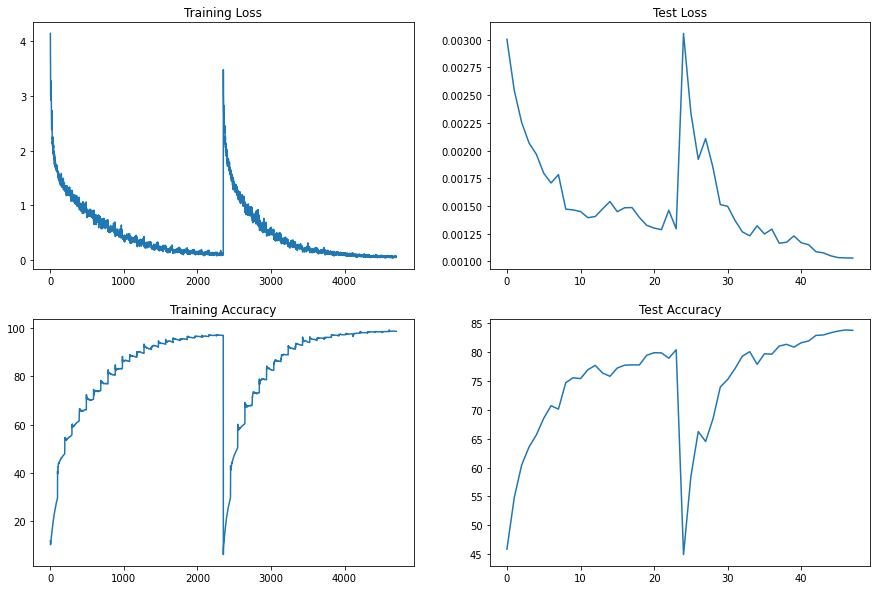

In [14]:
# Visualize the Training/Test Accuracy/Loss using Matplotlib

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")